## Import necessary packages

In [26]:
import torch
import torchvision
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from utils import *
from model import SiameseNetwork
from loss import ContrastiveLoss
from dataset import ATATContrast
from torchsummary import summary
from matplotlib import pyplot as plt
import os
from glob import glob
import random
from sklearn.metrics import classification_report
import shutil

# Prepare the data file

In [27]:
os.mkdir("train_test_val")
os.mkdir("train_test_val/train")
os.mkdir("train_test_val/test")
os.mkdir("train_test_val/val")

for i in ["train","test","val"]:
    for j in range(1,41):
        os.mkdir(f"train_test_val/{i}/s{j}")
        
        
for i in os.listdir("../archive (2)"):
    if i == ".DS_Store":
        continue
    if i =="README":
        continue
    
    images=glob(f"../archive (2)/{i}/*.pgm")
    

    #train
    for img in random.sample(images, 6):
        shutil.copyfile(img, f"train_test_val/train/{i}/{img.split('/')[-1]}")
        images.remove(img)
        
    #test
    for img in random.sample(images, 2):
        shutil.copyfile(img, f"train_test_val/test/{i}/{img.split('/')[-1]}")
        images.remove(img)
    
    #val
    for img in random.sample(images, 2):
        shutil.copyfile(img, f"train_test_val/val/{i}/{img.split('/')[-1]}")
        images.remove(img)
    
    

## Initialize batch size and hyperparameters
The margin and threshold were changed to perform well on the validation set

In [28]:
path = 'train_test_val'

## Initialize parameters
bs = 32
lr = 8e-3
threshold = 0.1
margin = 1.0
epochs = 15


## Initialize network variables

In [29]:
## Initialize network
model = SiameseNetwork()
model = model.to("mps")

model.apply(initialize_weights)

## Initialize optimizer
optim = torch.optim.Adam(model.parameters(),lr=lr)

## Initialize scheduler
scheduler = torch.optim.lr_scheduler.StepLR(optim,5,gamma=0.3)

## Initialize loss
criterion = ContrastiveLoss(margin)

## Create Datasets and Dataloaders

In [30]:
## Initialize datasets and dataloaders
train_transforms = torchvision.transforms.Compose([
            torchvision.transforms.RandomHorizontalFlip(),
            torchvision.transforms.RandomRotation(45),
            torchvision.transforms.ToTensor()
        ])

valid_transforms = torchvision.transforms.Compose([
            torchvision.transforms.ToTensor()
        ])

test_transforms = torchvision.transforms.Compose([
            torchvision.transforms.ToTensor()
        ])

train_ds = ATATContrast(ImageFolder(root = path + '/train',transform=train_transforms))
valid_ds = ATATContrast(ImageFolder(root = path + '/val',transform=valid_transforms))
test_ds = ATATContrast(ImageFolder(root = path + '/test',transform=test_transforms))

train_dl = DataLoader(train_ds,batch_size=bs)
valid_dl = DataLoader(valid_ds,batch_size=bs)
test_dl = DataLoader(test_ds,batch_size=bs)


## Train the model

In [31]:
train_loss = []
valid_loss = []
for epoch in range(epochs):
    train_epoch_loss = 0
    model.train()    
      
    for i,(input1,input2,target) in enumerate(train_dl):
        optim.zero_grad()
        output1,output2 = model(input1.to("mps"),input2.to("mps"))
        out = model(input1.to("mps"),input2.to("mps"))
        
        loss = criterion(output1,output2,target.to("mps"))
        train_epoch_loss += loss.item()
        loss.backward()
        optim.step()
    
    train_epoch_loss /= len(train_ds)
    train_loss.append(train_epoch_loss)
    
    print("Epoch [{}/{}] ----> Training loss :{} \n".format(epoch+1,epochs,train_epoch_loss))
    

    valid_epoch_loss = 0
    val_pos_accuracy = 0
    val_neg_accuracy = 0
    num_pos = 0
    num_neg = 0
    model.eval()

    for i,(input1,input2,target) in enumerate(valid_dl):
        output1,output2 = model(input1.to("mps"),input2.to("mps"))
        loss = criterion(output1,output2,target.to("mps"))
        valid_epoch_loss += loss.item()
        pos_acc,pos_sum,neg_acc,neg_sum = evaluate_pair(output1,output2,target.to("mps"),threshold)
        val_pos_accuracy+=pos_acc
        val_neg_accuracy+=neg_acc
        num_pos+=pos_sum
        num_neg+=neg_sum

    valid_epoch_loss /= len(valid_ds)
    val_pos_accuracy /= num_pos
    val_neg_accuracy /= num_neg

    valid_loss.append(valid_epoch_loss)



    print("Validation loss :{} \t\t\t P Acc : {}, N Acc: {}\n".format(valid_epoch_loss,val_pos_accuracy,val_neg_accuracy))
    


Epoch [1/15] ----> Training loss :8.388591914872329 

Validation loss :0.06346594244241714 			 P Acc : 0.6578947368421053, N Acc: 0.8571428571428571

Epoch [2/15] ----> Training loss :0.01074241924022014 

Validation loss :0.005611353646963834 			 P Acc : 0.7297297297297297, N Acc: 0.7906976744186046

Epoch [3/15] ----> Training loss :0.013194686081260443 

Validation loss :0.005014463281258941 			 P Acc : 0.7560975609756098, N Acc: 0.8205128205128205

Epoch [4/15] ----> Training loss :0.010476021282374858 

Validation loss :0.007535606063902378 			 P Acc : 0.782608695652174, N Acc: 0.7058823529411765

Epoch [5/15] ----> Training loss :0.016441297841568787 

Validation loss :0.00535134095698595 			 P Acc : 0.7631578947368421, N Acc: 0.7619047619047619

Epoch [6/15] ----> Training loss :0.01124497726559639 

Validation loss :0.009486503526568412 			 P Acc : 0.675, N Acc: 0.725

Epoch [7/15] ----> Training loss :0.0102812380840381 

Validation loss :0.005326654482632876 			 P Acc : 0.731

## Plot losses

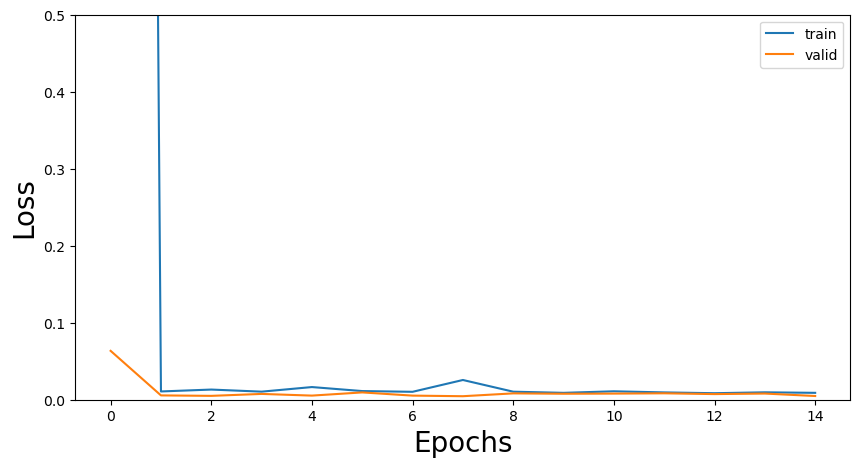

In [32]:
plt.figure(figsize = (10,5))
plt.plot(train_loss,label = 'train')
plt.plot(valid_loss,label = 'valid')
plt.xlabel("Epochs",size = 20)
plt.ylabel("Loss", size = 20)
plt.ylim(0,0.5)
plt.legend()
plt.show()

## Plot images from test set and compare distances

In [33]:
def show(img,ax,d):
    npimg = img.numpy()
    ax.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')
    ax.set_title("Dissimilarity:"+str(round(d[0],5)),fontweight = "bold", size = 24)
    ax.set_xticks([])
    ax.set_yticks([])

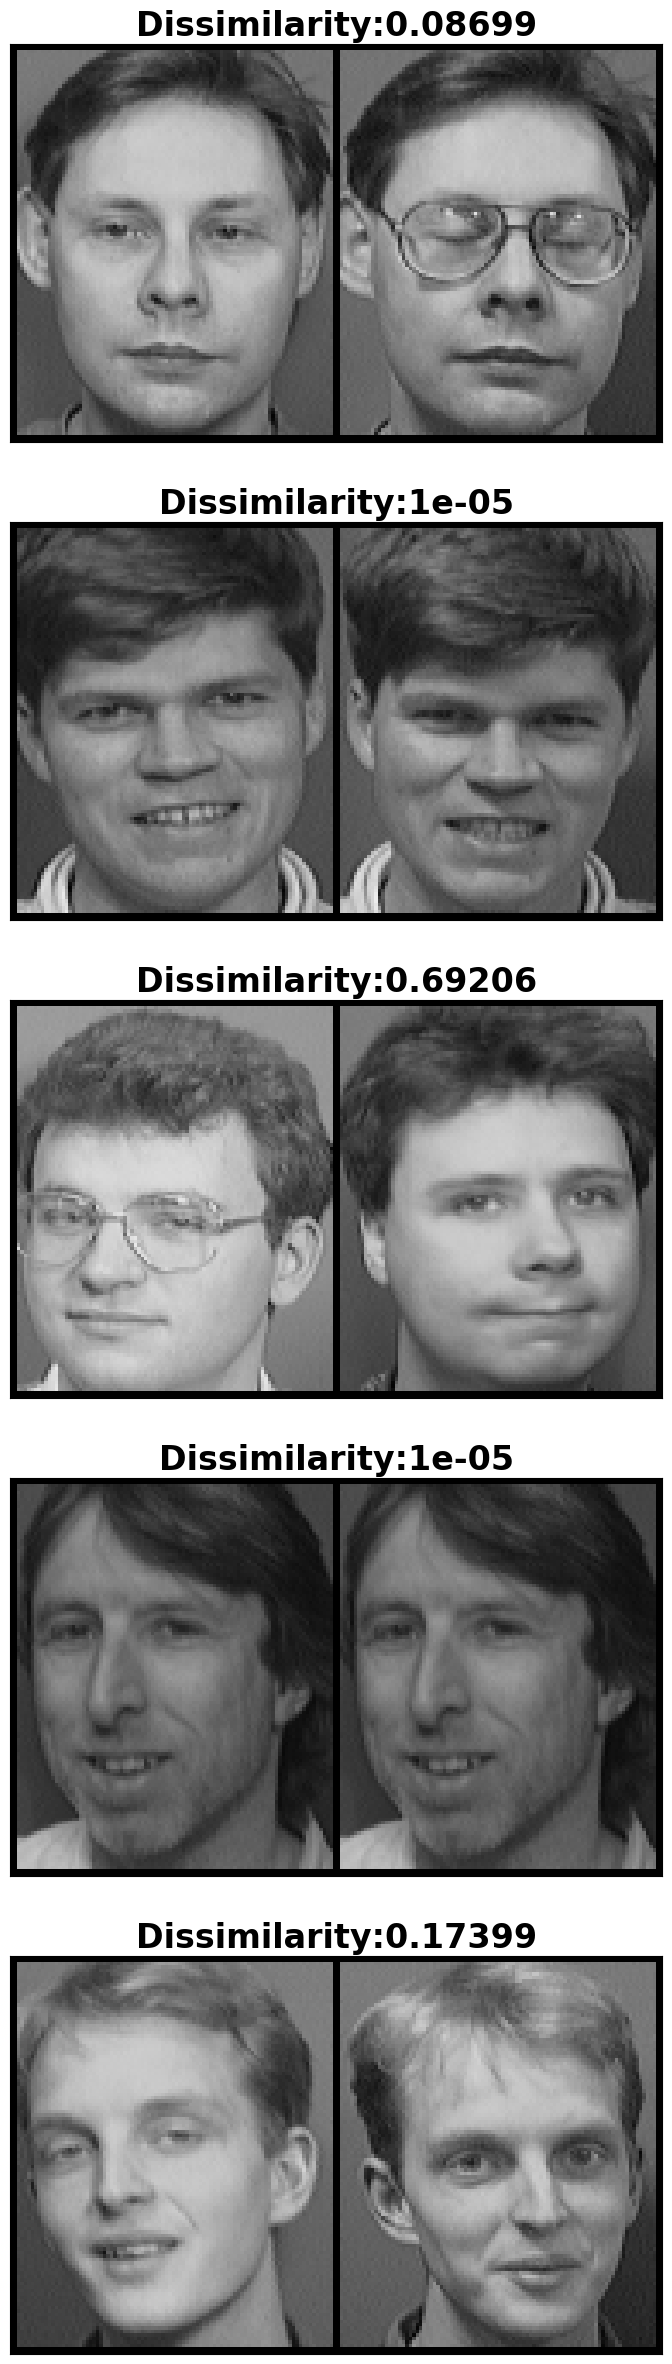

In [39]:
fig,ax = plt.subplots(5,1,figsize = (30,30))
for i in range(5):
    idx = np.random.randint(0,len(test_ds))
    input1,input2,target = test_ds[idx]
    model=model.to("mps")
    output1,output2 = model(input1.unsqueeze(0).to("mps"),input2.unsqueeze(0).to("mps"))
    grid = torchvision.utils.make_grid([input1,input2])
    euclidean_distance = F.pairwise_distance(output1,output2)
    
    show(grid,ax[i],euclidean_distance.cpu().detach().numpy())
plt.show()

In [35]:
model=model.to("mps")
preds=[]
actual=[]
for input1,input2,target in train_ds:
    actual.append(target)
    output1,output2 = model(input1.unsqueeze(0).to("mps"),input2.unsqueeze(0).to("mps"))
    pred=int(F.pairwise_distance(output1,output2)>threshold)
    preds.append(pred)
    
print(classification_report(preds,actual))

              precision    recall  f1-score   support

           0       0.71      0.93      0.81        87
           1       0.95      0.78      0.86       153

    accuracy                           0.84       240
   macro avg       0.83      0.86      0.83       240
weighted avg       0.86      0.84      0.84       240



In [36]:
model=model.to("mps")
preds=[]
actual=[]
for input1,input2,target in test_ds:
    actual.append(target)
    output1,output2 = model(input1.unsqueeze(0).to("mps"),input2.unsqueeze(0).to("mps"))
    pred=int(F.pairwise_distance(output1,output2)>threshold)
    preds.append(pred)
    
print(classification_report(preds,actual))

              precision    recall  f1-score   support

           0       0.81      0.66      0.72        38
           1       0.73      0.86      0.79        42

    accuracy                           0.76        80
   macro avg       0.77      0.76      0.76        80
weighted avg       0.77      0.76      0.76        80



In [37]:
model=model.to("mps")
preds=[]
actual=[]
for input1,input2,target in valid_ds:
    actual.append(target)
    output1,output2 = model(input1.unsqueeze(0).to("mps"),input2.unsqueeze(0).to("mps"))
    pred=int(F.pairwise_distance(output1,output2)>threshold)
    preds.append(pred)
    
print(classification_report(preds,actual))

              precision    recall  f1-score   support

           0       0.74      0.76      0.75        46
           1       0.67      0.65      0.66        34

    accuracy                           0.71        80
   macro avg       0.71      0.70      0.70        80
weighted avg       0.71      0.71      0.71        80



In [ ]:
from PIL import Image
def get_image_embedding(img_path):
    convert_tensor = torchvision.transforms.ToTensor()
    embd=model.forward_once(convert_tensor(Image.open(img_path).convert("RGB")).unsqueeze(0)).squeeze()
    return embd

get_image_embedding("00118_1_F.png")

## Save the trained model for future usage

In [40]:
torch.save(model.state_dict(),'./siameseNetowrk_final.pt')

In [ ]:
new_model = SiameseNetwork()
new_model.load_state_dict(torch.load('./siameseNetowrk_final.pt'))
new_model.eval()

SiameseNetwork(
  (resnet): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(